# EN.535.610 Spring 2023 Project Code

### Authors: Chris Hennessy, Stephen Marinsek, Ryan Payne

### Group Alpha

## Import the required packages

In [1]:
#Import all required dependencies here

#These dependencies should be available by default via Anaconda install
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

from datetime import datetime
from datetime import timedelta

#These dependenies may need to be installed by the user and may not have
#come pre-installed with Anaconda
import xraydb

#Import Matplotlib and configure inline plotting
#Setting up options for plotting
%matplotlib inline
#Settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

## Define the required classes for the computation

In [8]:
#Create a class to define internal nodes
#Where x-rays will be absorbed and heat transfer will occur through conduction only
class InternalElement:
    """This class is used by the Section class (via composition design pattern) and represents an internal,
    solid element of material. These elements absorb cold x-rays and transmit heat via conduction only."""
    
    #Class constructor
    def __init__(self,  
                 t_conductivity,
                 spec_heat,
                 cs_area, 
                 ic_temp, 
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density,
                 emissivity):
        """InternalElement Class Constructor
        This function is used to enter the material properties and initial conditions for each element.
        Inputs:
            t_conductivity <float>: Thermal conductivity of the element's material
            spec_heat <float>: Specific heat of the element's material
            cs_area <float>: The cross-sectional area of the element
            ic_temp <float>: The initial condition for temperature of the element
            element_length <float>: The length of the element (colinear w/ x-ray direction)
            ablation_temp <float>: The temperature at which the material ablates
            rad_abs_coefficient <float>: The mass attenuation factor of the material
            density <float>: The density of the material
        Outputs:
            None"""
        
        #Initialize instance state
        self.absorbed_energy = 0
        self.rem_energy_flux = 0
        self.temp = ic_temp
        self.t_conductivity = t_conductivity
        self.spec_heat = spec_heat
        self.cs_area = cs_area
        self.nm1_temp = 0
        self.nm0_temp = 0
        self.is_ablated = False
        self.element_length = element_length
        self.ablation_temp = ablation_temp
        self.rad_abs_coefficient = rad_abs_coefficient
        self.density = density
        self.emissivity = emissivity
        
    #Function to set the initial conditions for the element
    def set_ics(self, initial_temp):
        """This function is used to set the temperature initial condition of the element.
        Inputs:
            initial_temp <float>: The initial condition for temperature of the element
        Outputs:
            None"""
        
        self.nm1_temp = initial_temp
        
#Create a class to define the entire section of material
#The computation will be performed here
class Section:
    """This class is used to represent a cross-section of one or more materials which will absorb x-rays and undergo
    thermal changes."""
    
    eV_to_Joule = 1.602e-19
    
    #Class constructor
    def __init__(self):
        self.elements_list = []
        self.rem_elements = []
        self.has_run_rad = False
        self.has_run_ablation = False
        self.has_run_temp = False
    """InternalElement Class Constructor
        This function is used to initialize variables for a Section class instance. No inputs are required by the user
        at this step.
        Inputs:
            None
        Outputs:
            None"""
        
    #Function to add a material layer to the section
    #Materials added from foreward (x-ray incoming direction) and populates back
    def add_matl(self,
                 quantity,
                 t_conductivity,
                 spec_heat,
                 cs_area,
                 ic_temp,
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density,
                 emissivity):
        """add_matl function
        This function is used to add a new thickness of material. Call this function multiple times to add additional
        material layers. Subsequent calls will add material to the back (away from initial x-ray impingment surface)
        Inputs:
            quantity <int>: Number of elements in the section of material
            t_conductivity <float>: The material's thermal conductivity
            spec_heat <float>: The material's specific heat
            cs_area <float>: The cross sectional area for the 1D material section (normal to x-rays)
            ic_temp <float>: Initial temperature of the material
            element_length <float>: The length of each element in the material layer
            ablation_temp <float>: The temperature at which the material will ablate
            rad_abs_coefficient <float>: The mass attenuation factor of the material
            density <float>: The density of the material
            emissivity <float>: The emissivity of the material
        Outputs:
            None"""
        
        for i in range(0, quantity):
            new_element = InternalElement(t_conductivity,
                                          spec_heat,
                                          cs_area,
                                          ic_temp,
                                          element_length,
                                          ablation_temp,
                                          rad_abs_coefficient,
                                          density,
                                          emissivity)
            self.elements_list.append(new_element)
        
    #Function to propagate x-rays through material
    def prop_xray_energy(self, tot_x_ray_energy):
        """prop_xray_energy function
        After all the layers of materials have been added, call this function to pass x-ray energy through
        the material section to calculate how much each element absorbs and the accompanying temperature change
        Inputs:
            tot_x_ray_energy <float>: Energy of all the x-rays to pass through the material's section [eV]
        Outputs:
            None"""
    
        tsprt_flux = tot_x_ray_energy
        for element in self.elements_list:
            delta_tsprt_flux = tsprt_flux * element.rad_abs_coefficient * element.density * element.element_length
            element.absorbed_energy = delta_tsprt_flux * Section.eV_to_Joule
            element.rem_energy_flux = tsprt_flux
            tsprt_flux = tsprt_flux - delta_tsprt_flux
            
        for element in self.elements_list:
            volume = element.cs_area * element.element_length
            element.temp = element.absorbed_energy / (volume*element.density*element.spec_heat) + element.temp
    
    #Function to get the total absorbed x-ray energy for each element
    def get_absorbed_energy(self):
        """get_absorbed_energy function
        After passing the x-ray energy through the material, use this function to get a list
        of the energy absorbed by each element.
        Inputs:
            None
        Outputs:
            Absorbed energy of each element <List of floats>"""
        
        absorbed_energy_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                absorbed_energy_list.append(element.absorbed_energy)
        
        return absorbed_energy_list
    
    #Function to get the remaining x-ray flux through each element
    def get_rem_energy(self):
        """get_rem_energy function
        After passing the x-ray energy through the material, use this function to get a list
        of the energy that passes through each element.
        Inputs:
            None
        Outputs:
            Remaining energy passing through each element <List of floats>"""
        
        rem_flux_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                rem_flux_list.append(element.rem_energy_flux)
                
        return rem_flux_list
    
    #Function to get the temperature distribution for each element
    def get_temperatures(self):
        """get_temperatures function
        After passing the x-ray energy through the material, use this function to get a list
        of the temperature for each element
        Inputs:
            None
        Outputs:
            Temperature of each element <List of floats>"""
        temp_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                temp_list.append(element.temp)
                
        return temp_list
    
    #Function to get a list of the distances of each node from the outermost surface
    def get_node_depths(self):
        """get_node_distances function
        After configuring the material section, use this function to return a list of the depth for each element.
        This is useful when plotting performance and parameters of the section as a function of distance.
        Inputs:
            None
        Outputs:
            Depth of each element <List of floats>"""
        
        dist_list = []
        dist = 0
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                dist_list.append(dist)
                dist += element.element_length
                
        return dist_list
    
    #Function to get a list of mass attenuation factors for each element
    def get_macs(self):
        """get_macs function
        After configuring the material section, use this function to return a list of the mass attenuation coefficient
        for each element.
        Inputs:
            None
        Outputs:
            Mass attenuation coefficient of each element <List of floats>"""
        
        mac_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                mac_list.append(element.rad_abs_coefficient)
                
        return mac_list
    
    #Function to get a list of densities for each element
    def get_densities(self):
        """get_densities function
        After configuring the material section, use this function to return a list of the density for each element.
        Inputs:
            None
        Outputs:
            Density of each element <List of floats>"""
        
        density_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                density_list.append(element.density)
                
        return density_list
    
    #Function to evaluate ablation
    def eval_ablation(self):
        
        for element in elements_list:
            if (element.nm0_temp >= element.ablation_temp):
                element.is_ablated = True
    
    #Function to initialize for transient thermal problem
    def init_transient_thermal(self, front_bc_ele, back_bc_ele):
        
        rem_elements = []
        rem_elements.append(front_bc_ele)
        for element in elements_list:
            if element.is_ablated == False:
                rem_elements.append(element)
        rem_elements.append(back_bc_ele)
    
    #Function to iterate through time for transient thermal analyses

    def transient_thermal_analysis(length, initial_temperature, total_time, time_step,
                                  thermal_conductivity, specific_heat, density, emissivity,
                                  solar_heat_flux):
        """
        Perform transient thermal analysis of a one-dimensional plate with radiation and solar heat flux.

        Args:
            length (float): Length of the plate in meters.
            initial_temperature (float): Initial temperature of the plate in Celsius.
            total_time (float): Total time of the analysis in seconds.
            time_step (float): Time step for the analysis in seconds.
            thermal_conductivity (float): Thermal conductivity of the material in W/(m*K).
            specific_heat (float): Specific heat of the material in J/(kg*K).
            density (float): Density of the material in kg/m^3.
            emissivity (float): Emissivity of the material.
            solar_heat_flux (float): Solar heat flux on the plate in W/m^2.

        Returns:
            numpy.ndarray: Array of temperature values at each time step.
        """
        # Define grid spacing, 
        # This section will need to be updated to include our number of elements and thickness of each element from the analysis performed below.
        # We can run this in 2 senarios, nominal before cold xray exposure, and after abaltion to ensure we can still dissapate the heat.
        # may need to update the code to include an internal heat source or power generation.
        num_x_points = 51
        delta_x = length / (num_x_points - 1)

        # Initialize temperature distribution
        # This will be set up as a steady state initial temperature from the cold xrays after the exposure.
        temperature = np.full(num_x_points, initial_temperature)

        # Perform transient thermal analysis
        num_time_steps = int(total_time / time_step)
        for t in range(num_time_steps):
            # Update temperature distribution using finite difference method
            for i in range(1, num_x_points - 1):
                # Radiative heat transfer
                radiation = emissivity * 5.67e-8 * (temperature[i]**4 - 273.15**4) # Stefan-Boltzmann law
                # Solar heat flux
                solar_flux = solar_heat_flux / (density * specific_heat)
                temperature[i] += time_step * (thermal_conductivity *
                                               (temperature[i+1] + temperature[i-1] - 2 * temperature[i]) /
                                               (density * specific_heat * delta_x**2) -
                                               radiation / (density * specific_heat) +
                                               solar_flux)

            # Apply boundary conditions
            # one side will be black body space
            # the other will be a constant temperature at the mounting location of a space vehicle
            temperature[0] = temperature[1] # Fixed temperature at left edge
            temperature[-1] = temperature[-2] # Fixed temperature at right edge

        return temperature

        #Functions to return results

## Analysis Section

### Define the Cold X-Ray Profile from Literature

In [9]:
#Define the cold x-ray profile outlined in M.S. Smith et al
#Corresponds to a 1.5M Ton Device at 10 km distance
i_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
i_energy = 13.5e3 #[eV], Average energy of x-rays from event

### Use XrayDB Library to Pull Mass Attenuation Coefficients

Units are converted to m, kg, s for consistency

In [10]:
al_mac = xraydb.mu_elam('Al', i_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]
print('Aluminum Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(al_mac))

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]
print('Aluminum Density: {0:.1f} [kg/m^3]'.format(al_dens))

carb_mac = xraydb.mu_elam('C', i_energy) #[cm^2/g]
carb_mac = carb_mac / 10 #[m^2/kg]
print('Carbon Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(carb_mac))

oxygen_mac = xraydb.mu_elam('O', i_energy) #[cm^2/g]
oxygen_mac = oxygen_mac / 10 #[m^2/kg]
print('Oxygen Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(oxygen_mac))

hydrogen_mac = xraydb.mu_elam('H', i_energy) #[cm^2/g]
hydrogen_mac = hydrogen_mac / 10 #[m^2/kg]
print('Hydrogen Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(hydrogen_mac))

nitrogen_mac = xraydb.mu_elam('N', i_energy) #[cm^2/g]
nitrogen_mac = nitrogen_mac / 10 #[m^2/kg]
print('Nitrogen Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(nitrogen_mac))

pmf_c = 0.706 #Paint mass fraction of Carbon [-]
pmf_o = 0.171 #Paint mass fraction of Oxygen [-]
pmf_h = 0.085 #Paint mass fraction of Hydrogen [-]
pmf_n = 0.032 #Paint mass fraction of Nitrogen [-]
paint_mac = pmf_c * carb_mac + pmf_o * oxygen_mac + pmf_h * hydrogen_mac + pmf_n * nitrogen_mac
print('Paint Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(paint_mac))

paint_dens = 1500 #[kg/m^3]
print('Paint Density: {0:.2f} [kg/m^3]'.format(paint_dens))

Aluminum Mass Attenuation Coefficient: 1.08 [m^2/kg]
Aluminum Density: 2700.0 [kg/m^3]
Carbon Mass Attenuation Coefficient: 0.10 [m^2/kg]
Oxygen Mass Attenuation Coefficient: 0.25 [m^2/kg]
Hydrogen Mass Attenuation Coefficient: 0.04 [m^2/kg]
Nitrogen Mass Attenuation Coefficient: 0.16 [m^2/kg]
Paint Mass Attenuation Coefficient: 0.12 [m^2/kg]
Paint Density: 1500.00 [kg/m^3]


## Perform X-ray Propagation Step

In [21]:
#Configure additional material properties
al_k = 237 #Aluminum thermal conductivity [W/m*k] 
paint_k = 0.65 #Paint thermal conductivity [W/m*k] 

al_ab_temp = 1000.0 #Aluminum ablation temperature [K]
paint_ab_temp = 1000.0 #Paint ablation temperature [K]

al_c = 897.0 #Aluminum specific heat [J/kg*C]
paint_c = 300.0 #Paint specific heat [J/kg*C]

e_area = 0.1 #Element area (perpendicular to x-rays) [m^2]
ic_temp = 293.0 #Element initial temperature [K]

al_emissivity = 0.07 #Emissivity of aluminum [-] Absorbtivity = 0.41
paint_emissivity = 0.87 #Emissivity of paint [-] Absorbtivity = 0.92

#Configure elements and thicknesses for 0.2mm thick paint
#over 200 elements
p_elements = 200 #[-]
p_ele_thickness = 0.000001 #[m]

#Configure elements and thicknesses for 3.0mm thick aluminum
#over 3000 elements
al_elements = 3000 #[-]
al_ele_thickness = 0.000001 #[m]

#Instantiate section
rad_section = Section()

#Add paint layer
rad_section.add_matl(quantity=p_elements,
                     t_conductivity=paint_k,
                     spec_heat=paint_c,
                     cs_area=e_area,
                     ic_temp=ic_temp,
                     element_length=p_ele_thickness,
                     ablation_temp=paint_ab_temp,
                     rad_abs_coefficient=paint_mac,
                     density=paint_dens,
                     emissivity=paint_emissivity)

#Add aluminum layer
rad_section.add_matl(quantity=al_elements,
                     t_conductivity=al_k,
                     spec_heat=al_c,
                     cs_area=e_area,
                     ic_temp=ic_temp,
                     element_length=al_ele_thickness,
                     ablation_temp=al_ab_temp,
                     rad_abs_coefficient=al_mac,
                     density=al_dens,
                     emissivity=al_emissivity)

#Perform x-ray absorption analysis
rad_initial_temp = rad_section.get_temperatures() #Store initial temps for data vis
rad_section.prop_xray_energy(i_flux*i_energy)

#Store results needed for x-ray absorption results post-processing
rad_depth_list = rad_section.get_node_depths()
rad_absorbed_energy = rad_section.get_absorbed_energy()
rad_post_xray_temps = rad_section.get_temperatures()

#Perform ablation analysis

#Perform transient thermal analysis

## Visualize Results and Draw Conclusions

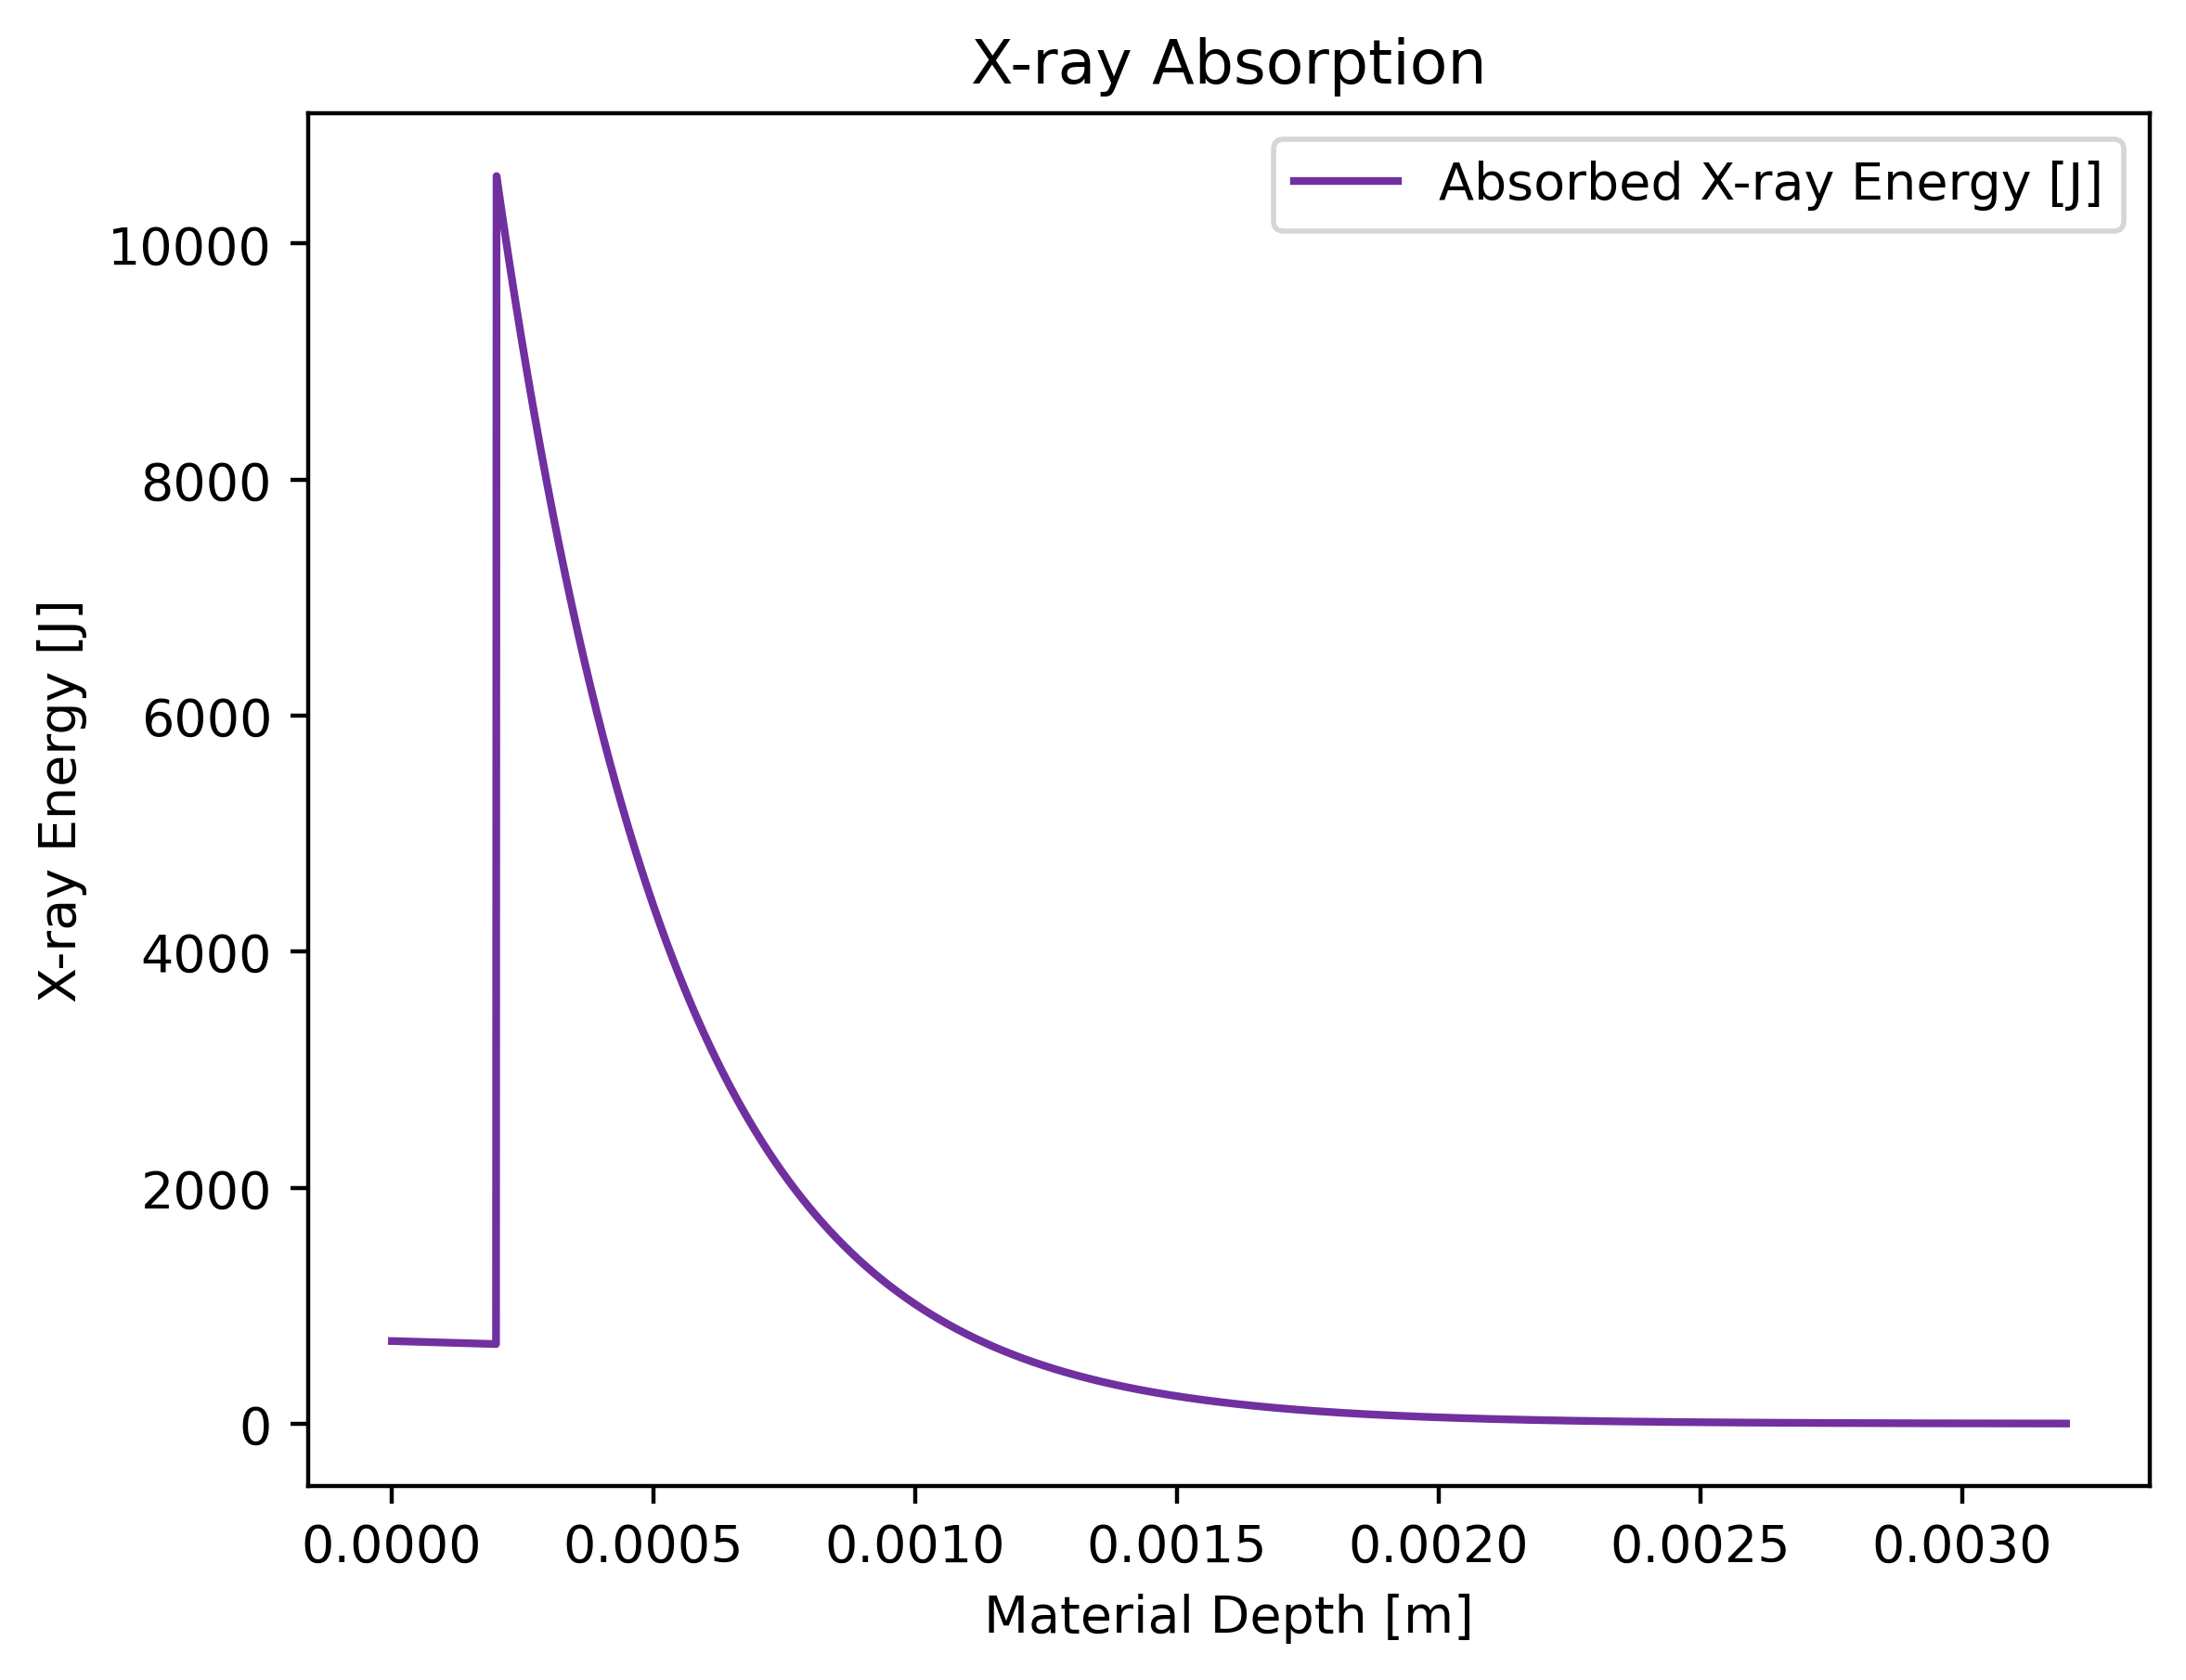

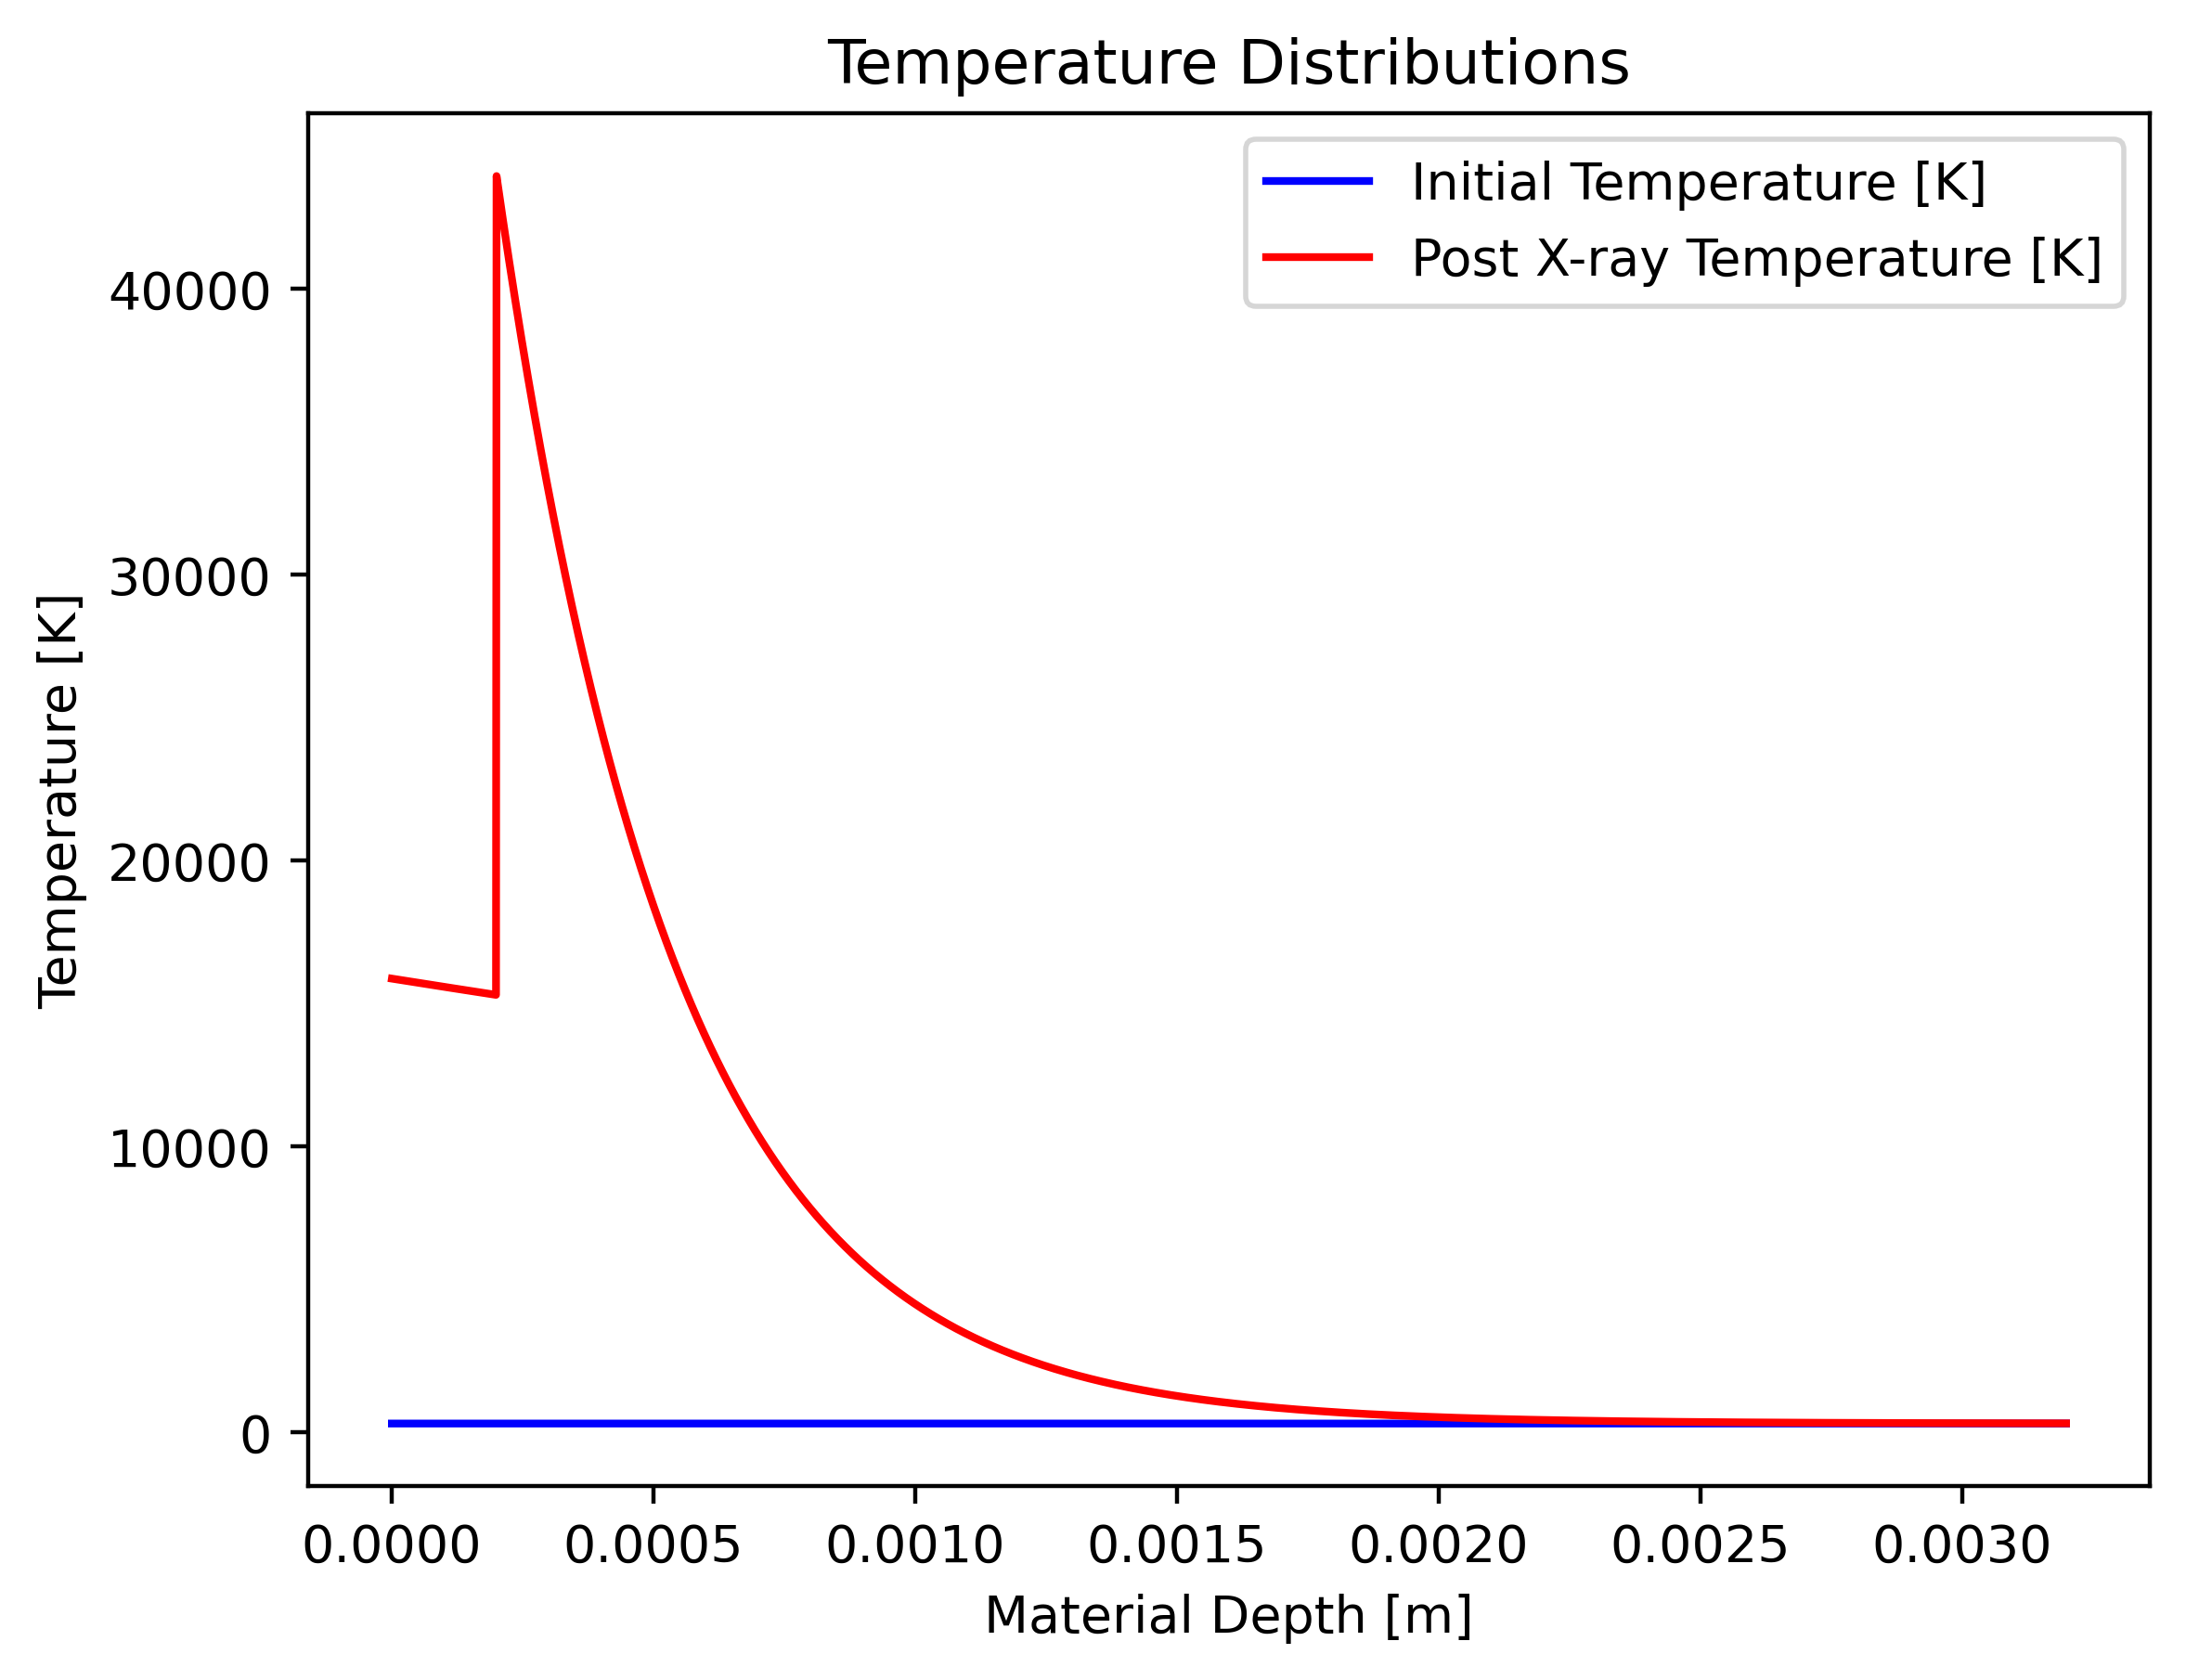

In [14]:
#Results visualization for x-ray absorption analysis

#Plot the energy absorbed by each element
fig, ax = plt.subplots()
ax.plot(rad_depth_list, rad_absorbed_energy, color=(112/255, 48/255, 160/255))
ax.set_title("X-ray Absorption")
ax.set_xlabel("Material Depth [m]")
ax.set_ylabel("X-ray Energy [J]")
ax.legend(["Absorbed X-ray Energy [J]"])
plt.show()
#fig.savefig("X-ray Absorption, Radiator Sim.png")

#Plot the the temperature of each element before and after x-ray exposure
fig, ax = plt.subplots()
ax.plot(rad_depth_list, rad_initial_temp, color=(0, 0, 1))
ax.plot(rad_depth_list, rad_post_xray_temps, color=(1, 0, 0))
ax.set_title("Temperature Distributions")
ax.set_xlabel("Material Depth [m]")
ax.set_ylabel("Temperature [K]")
ax.legend(["Initial Temperature [K]", "Post X-ray Temperature [K]"])
plt.show()
#fig.savefig("Post X-ray Temp, Radiator Sim.png")

# Verification, Validation, and Error Section

## Evaluate Error and Complexity of Numerical Solution for Absorbed X-rays

Since x-ray absorption for a monolithic material is the solution to a 1-dimensional ODE, we can directly compare numerical and analytical solutions for simple cases.

To verify, we analyze a single cross section of aluminum using the numerical method in our package and compare to the accepted analytical solution.

For this comparison, we use a 1 mm thick section of aluminum with increasing numbers of elements. The expectation is that the numerical solution will converge on the analytical solution as element quantity increases. Complexity is expected to scale linearly with increasing element counts

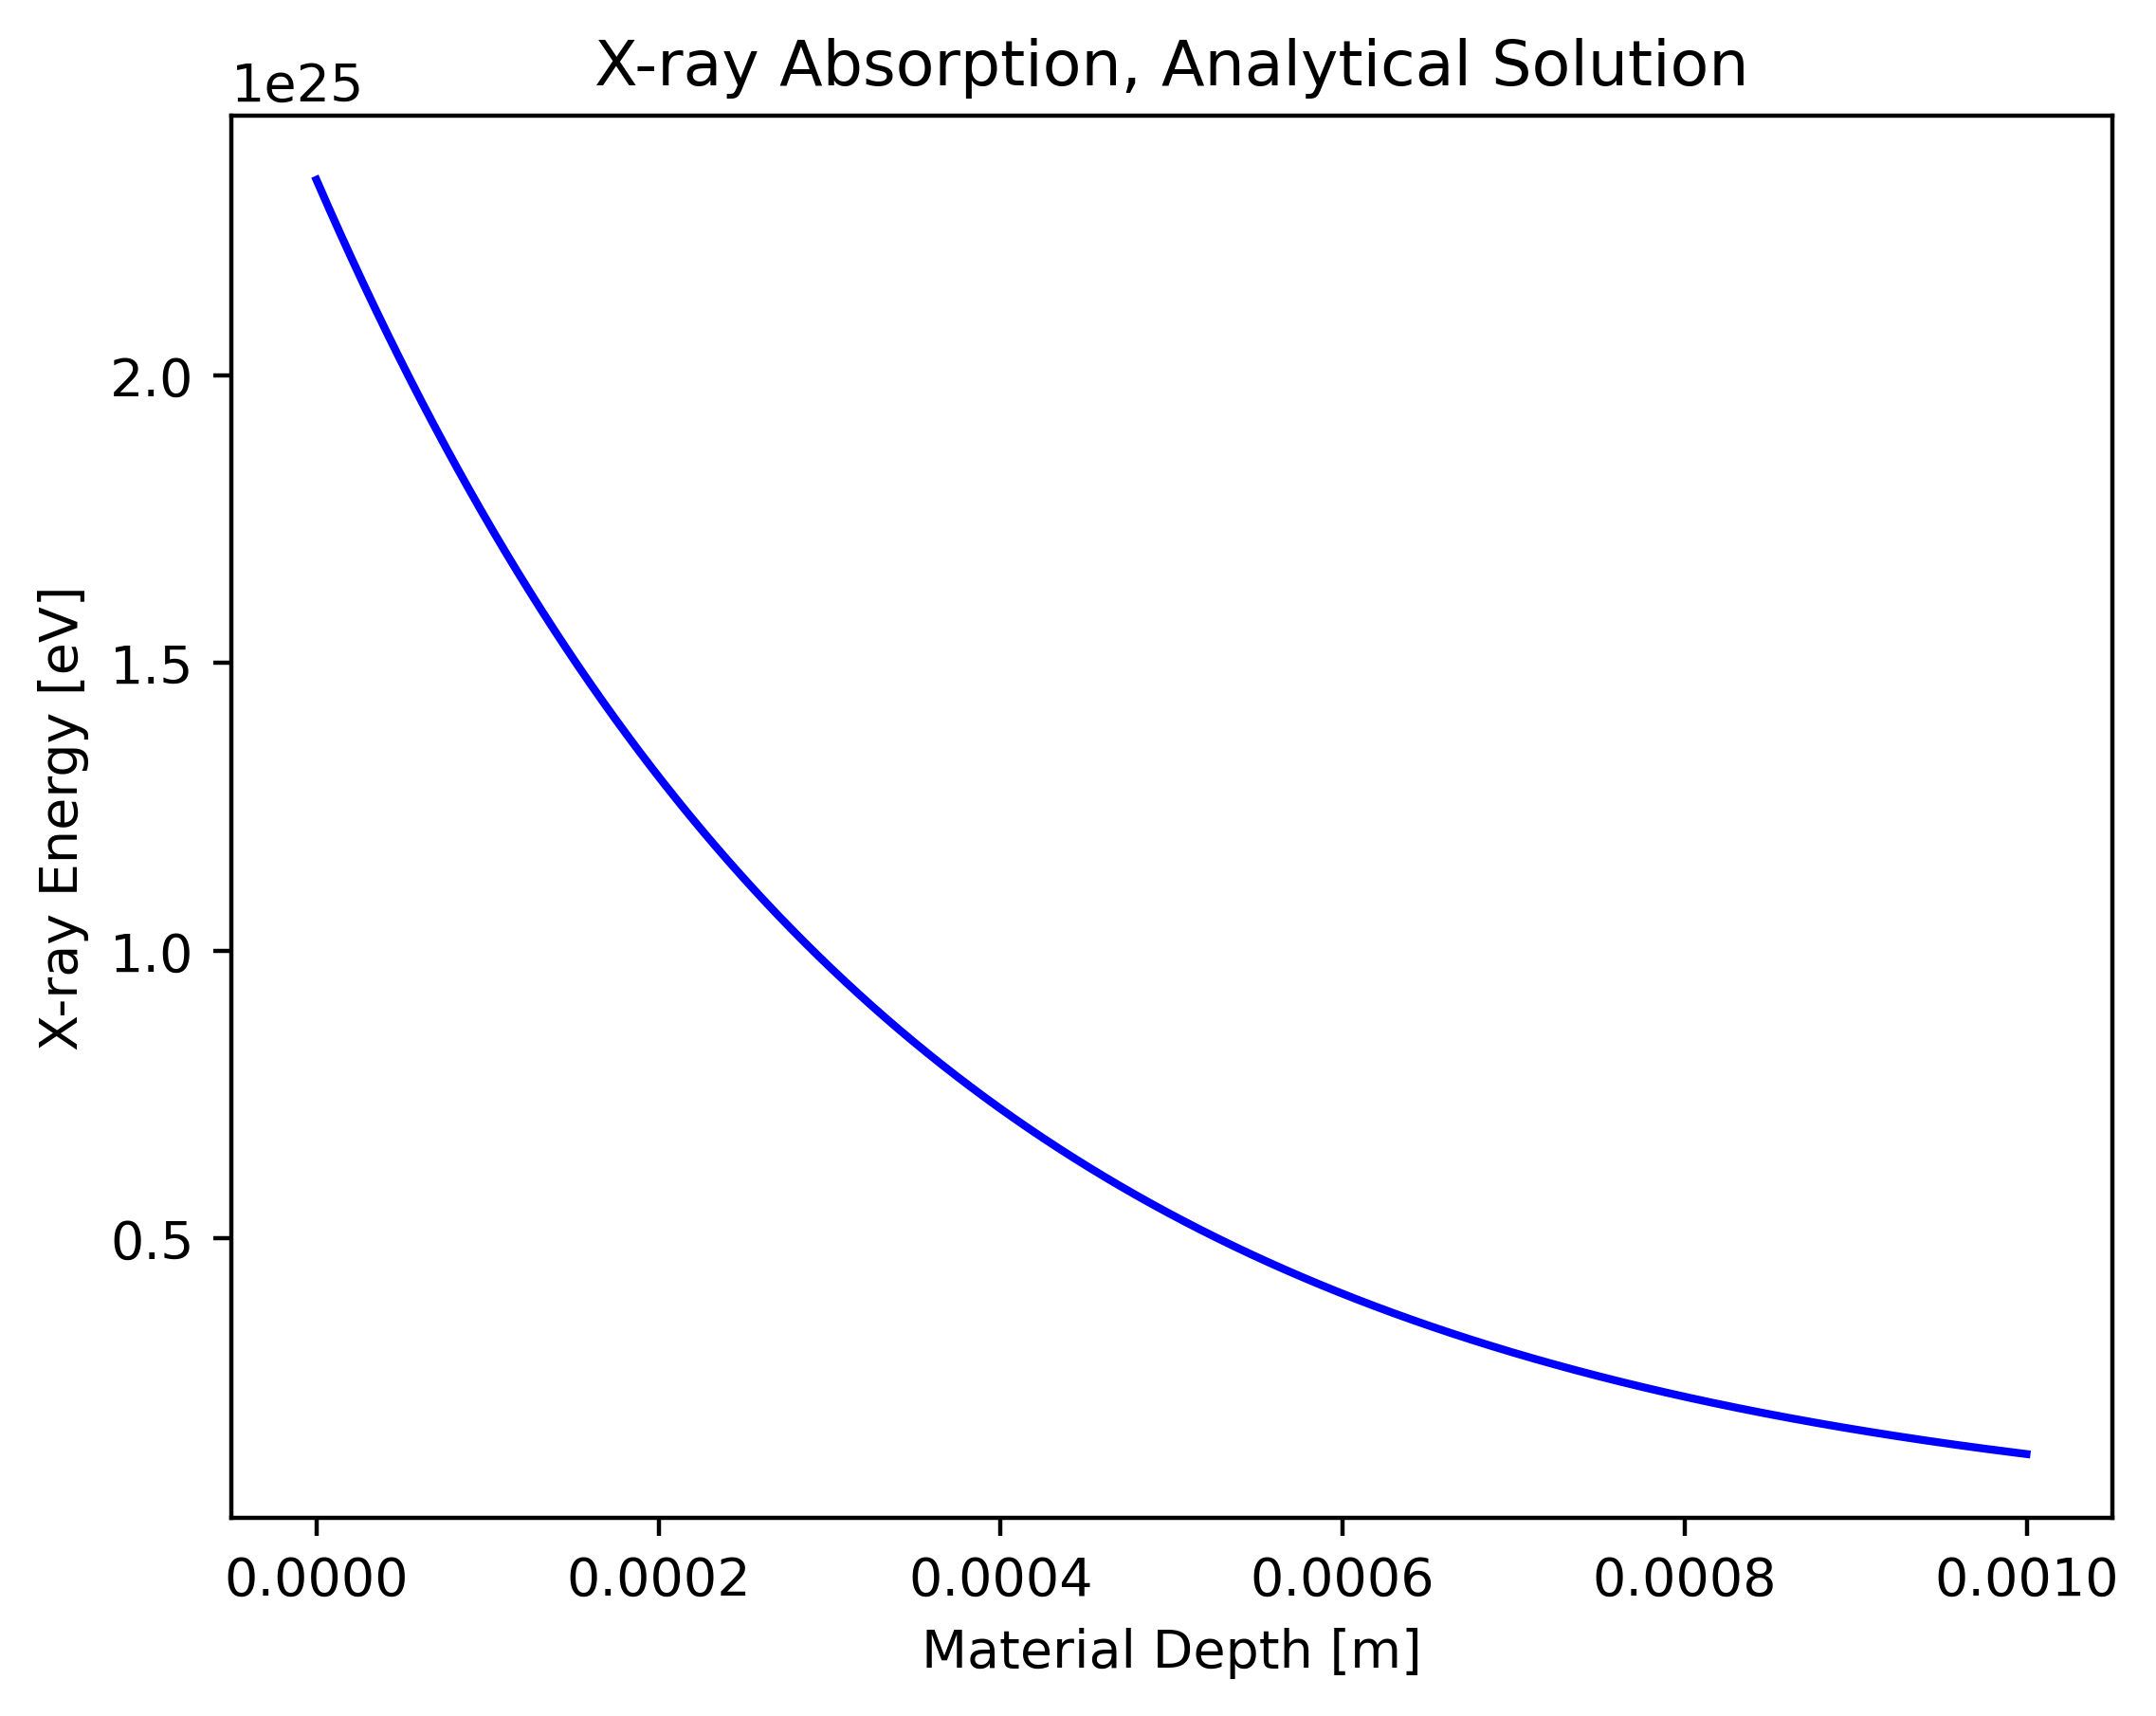

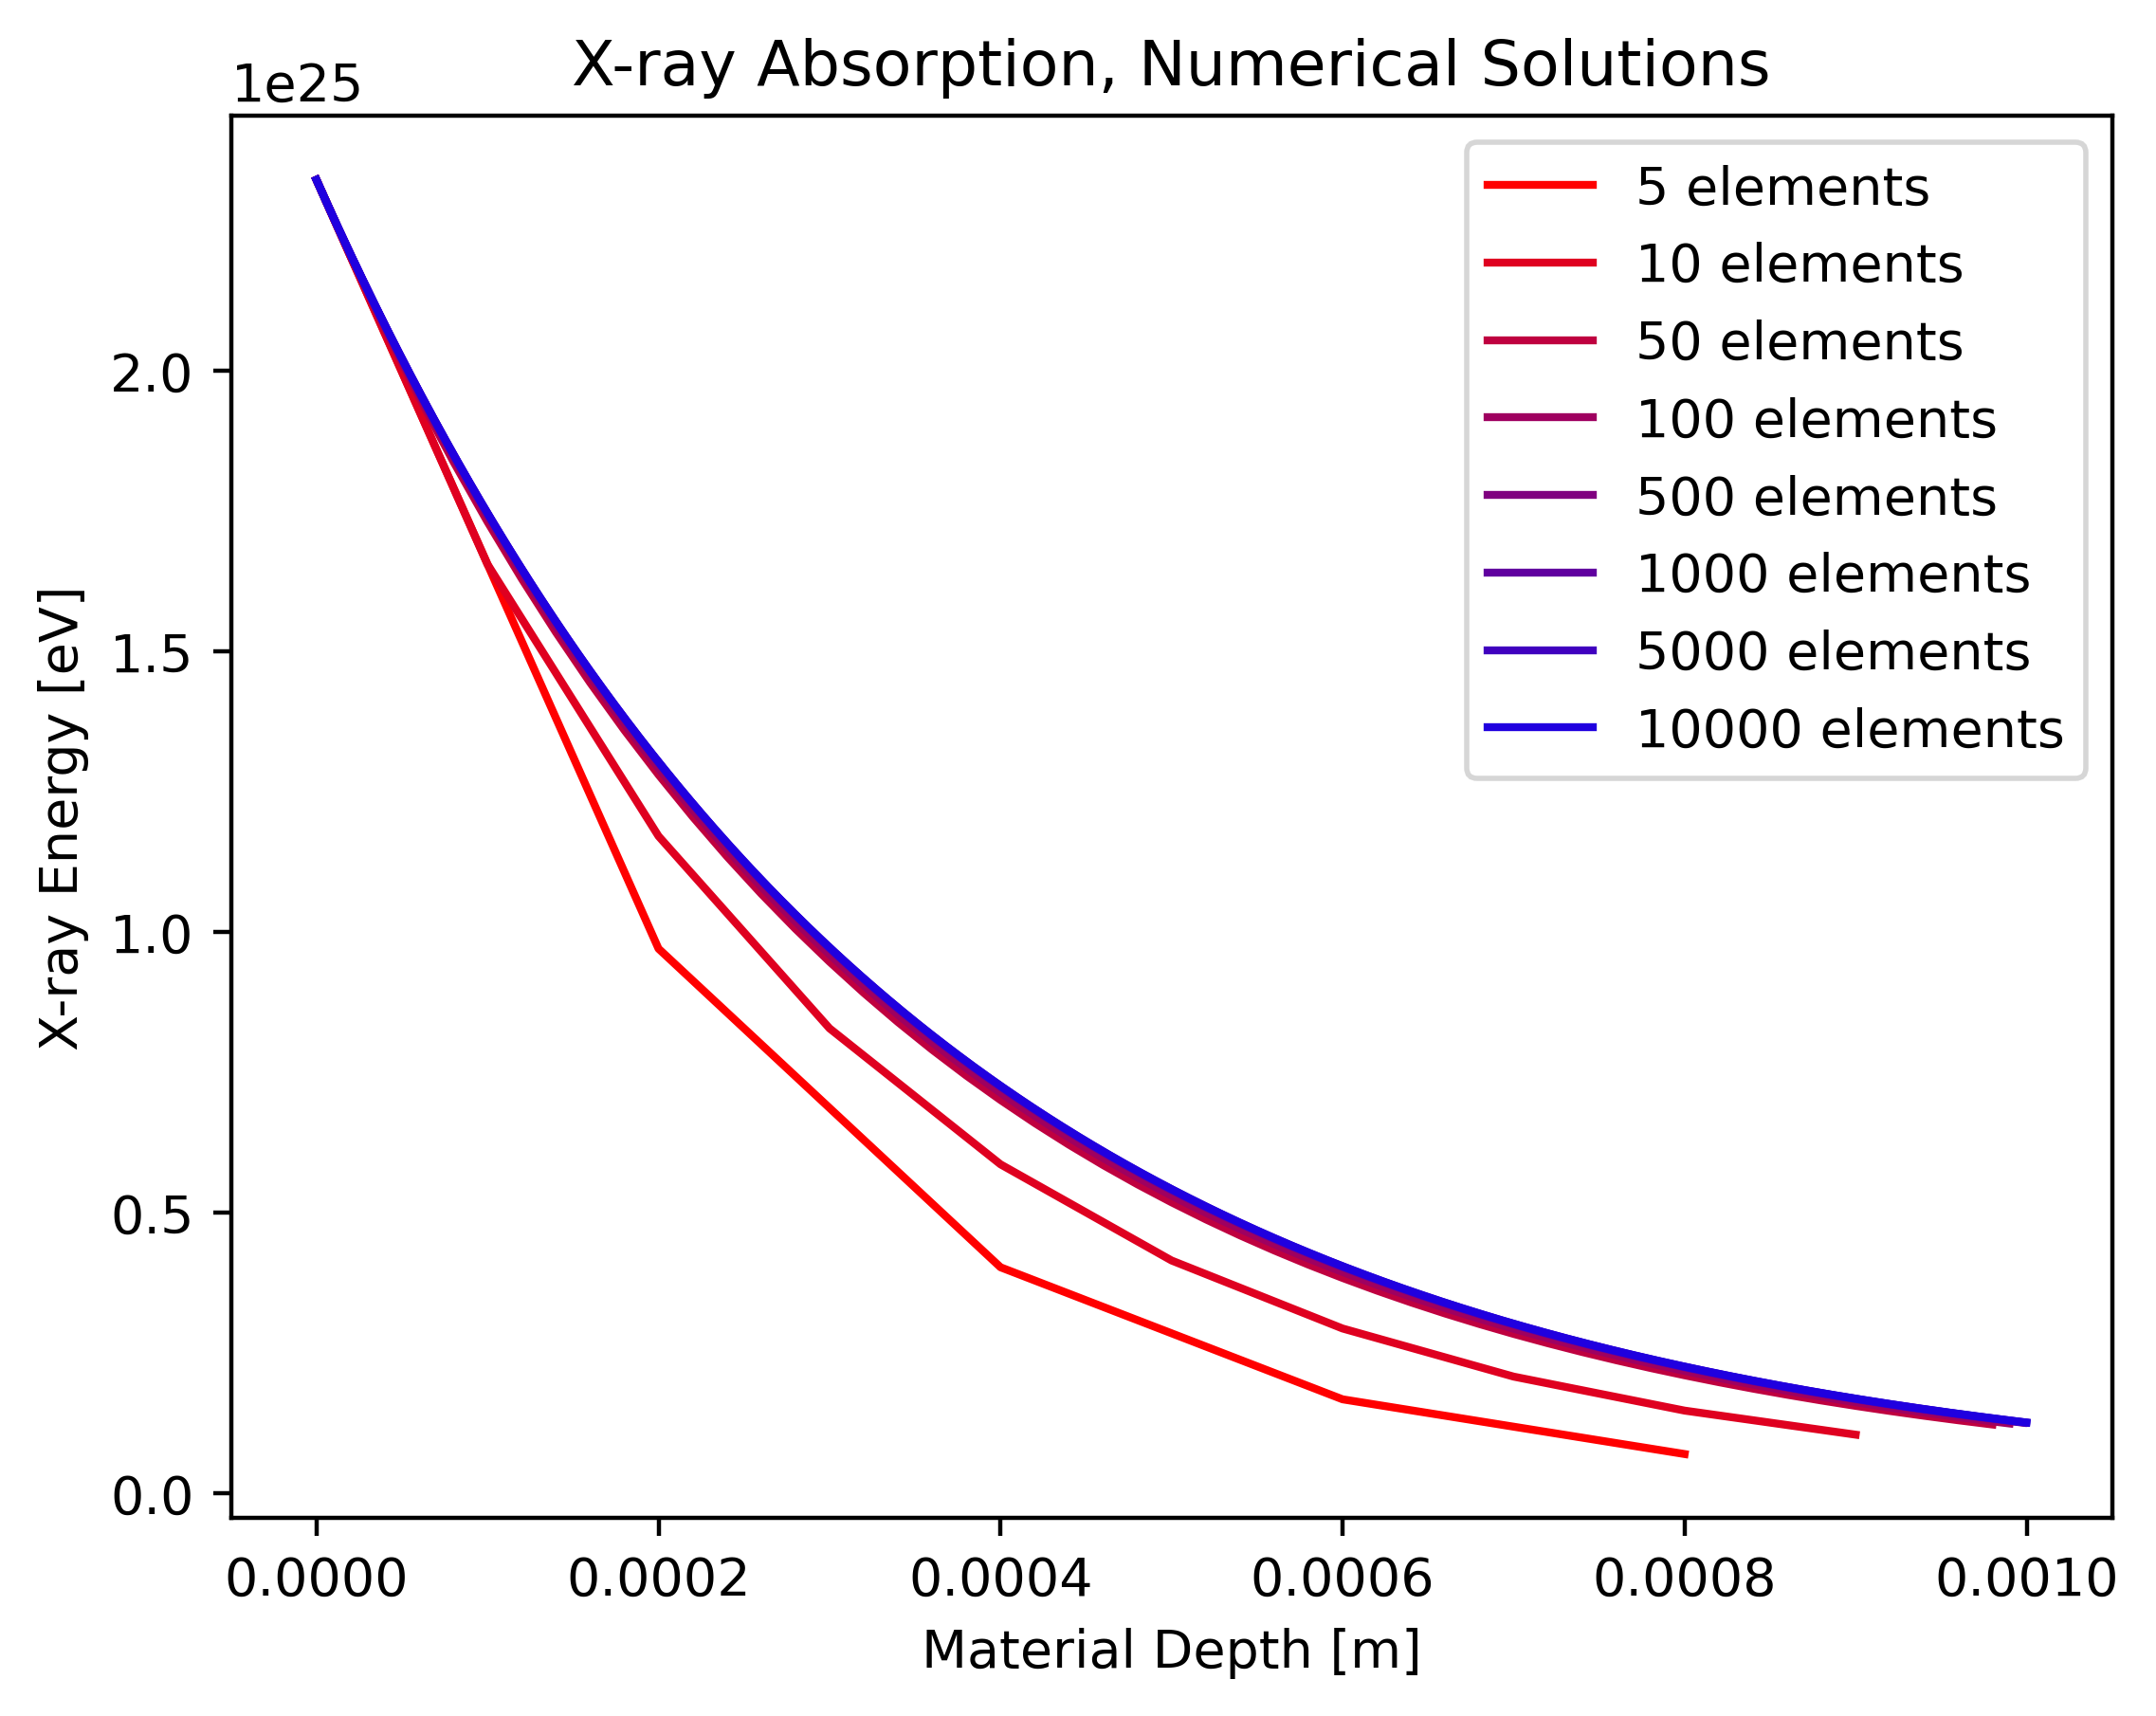

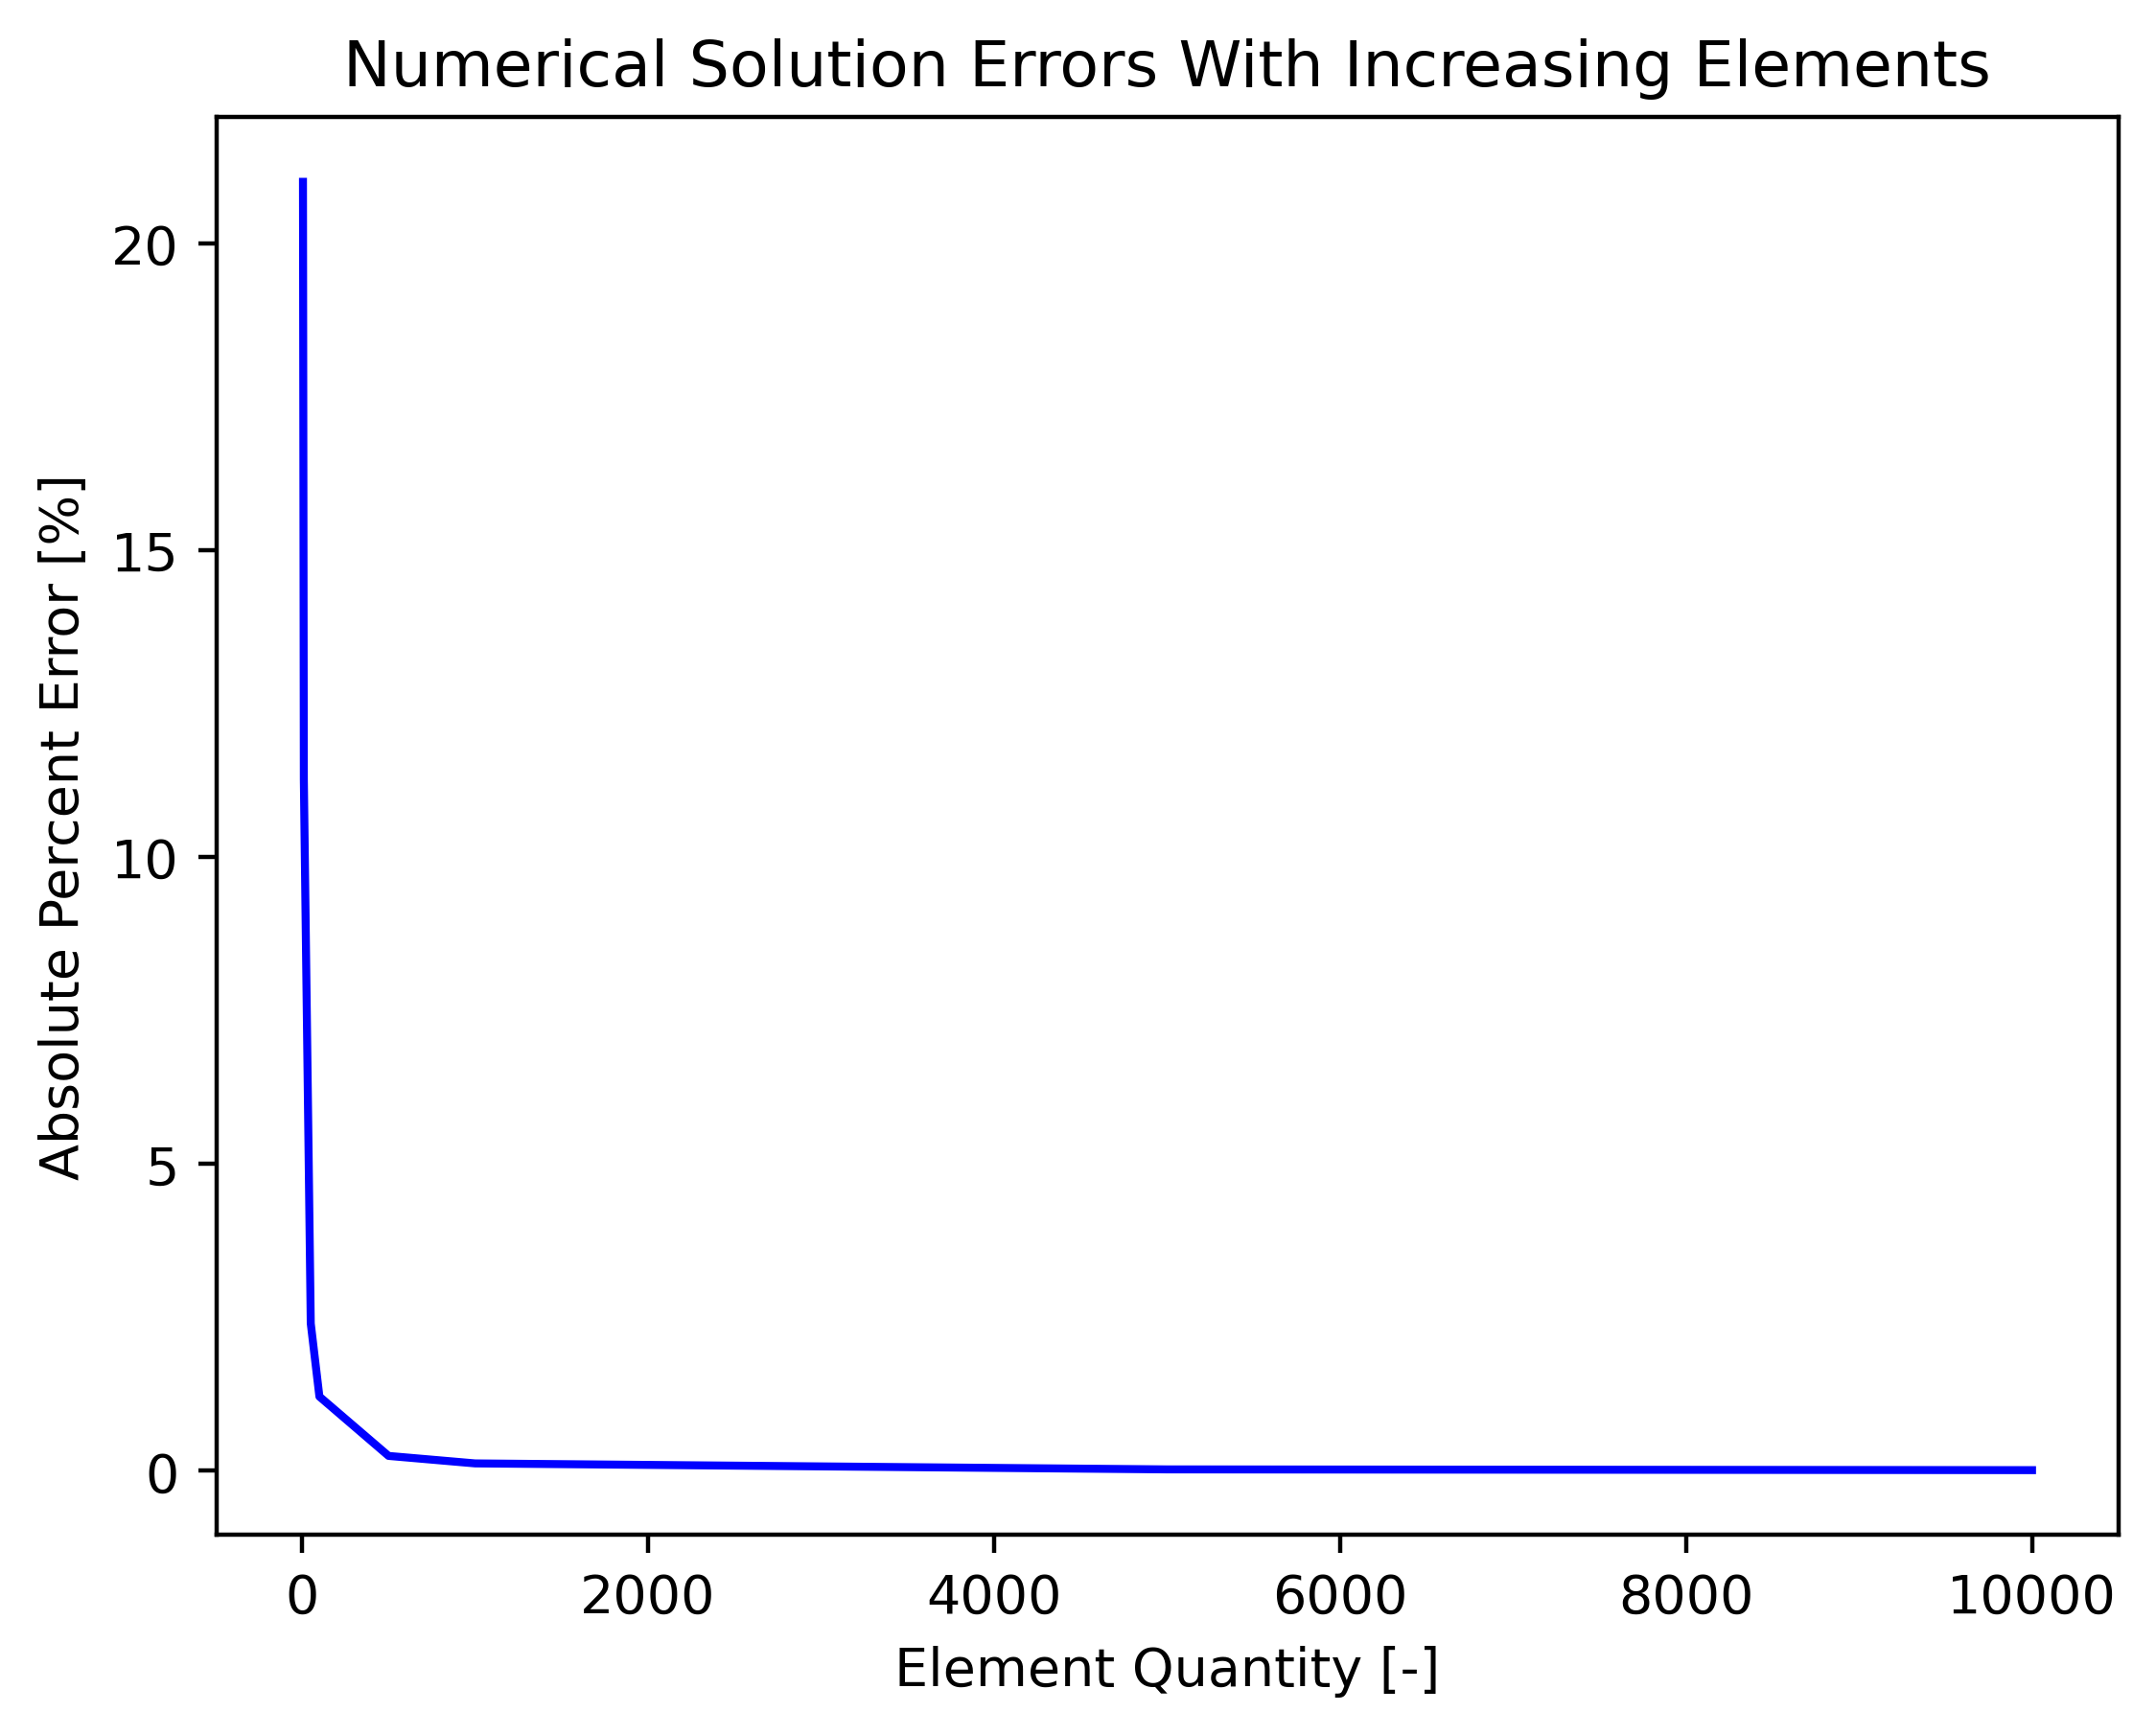

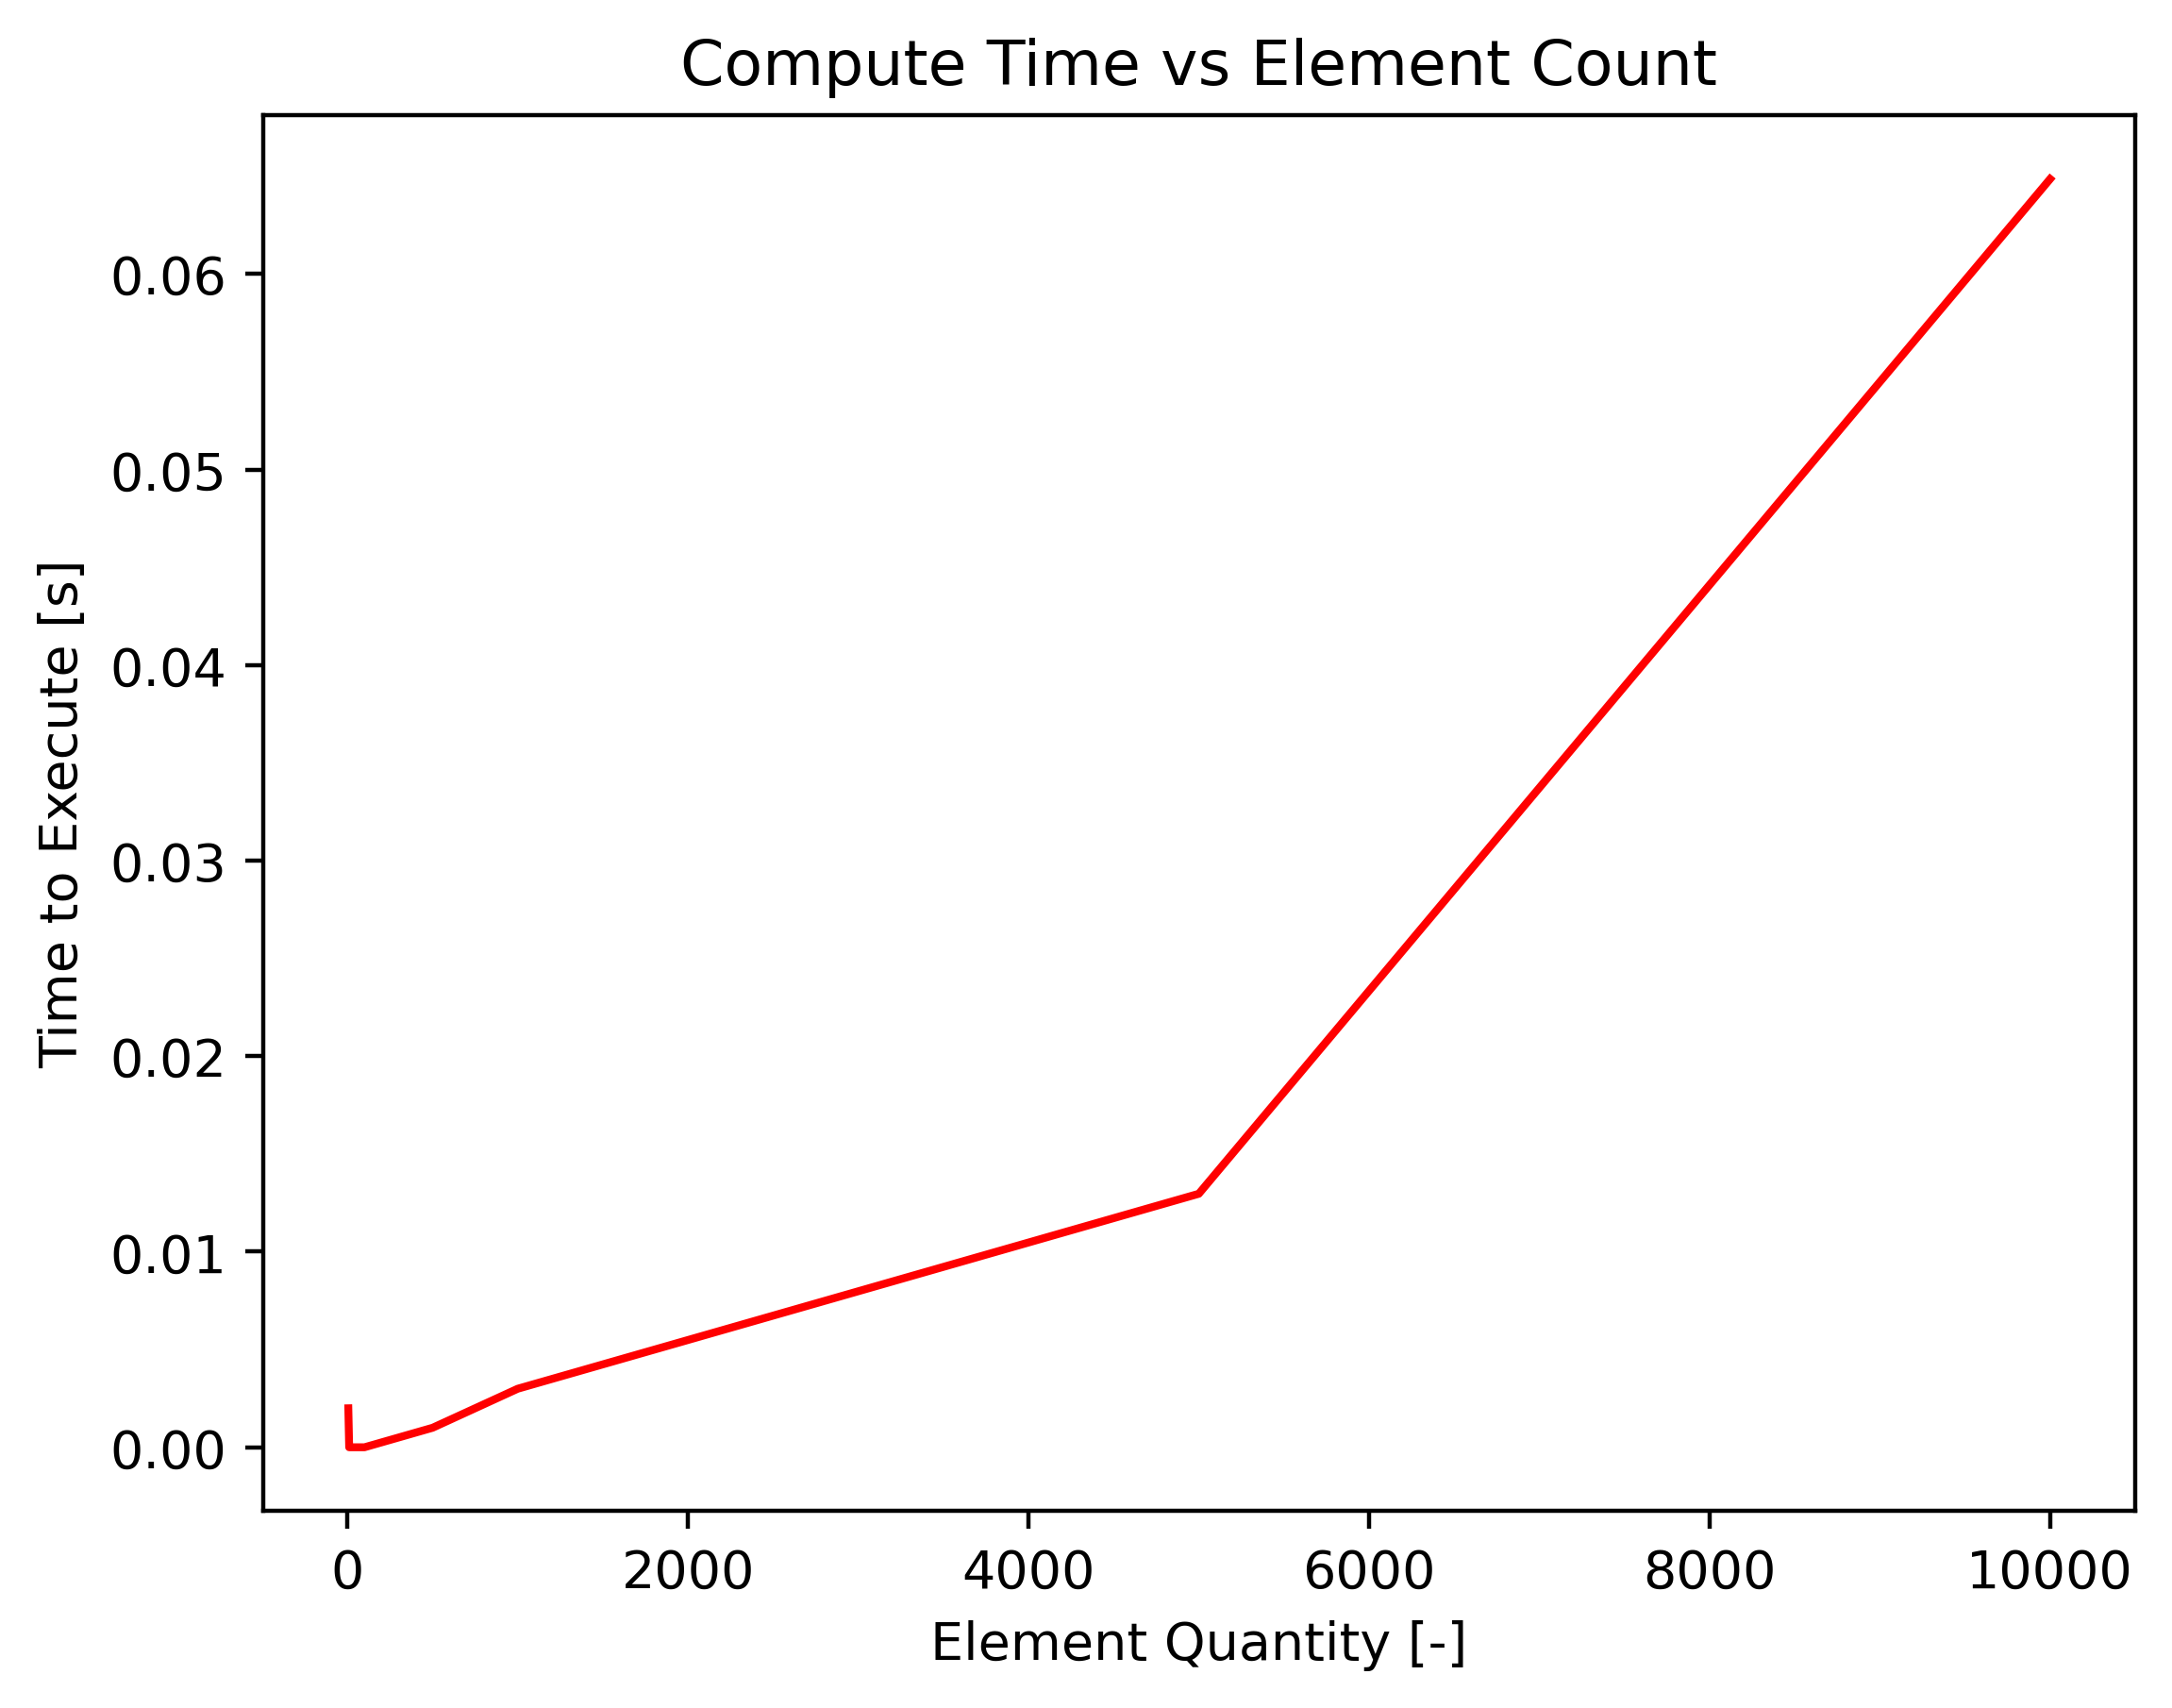

In [16]:
#Configure x-ray profile
v_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
v_energy = 13.5e3 #[eV], Average energy of x-rays from event

#Pull material data for aluminum
al_mac = xraydb.mu_elam('Al', v_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]

#Configure the test points
e_qty = [5, 10, 50, 100, 500, 1000, 5000, 10000] #[-]
e_thick = [0.0002, 0.0001, 0.00002, 0.00001, 0.000002, 0.000001, 2.0e-7, 1.0e-7] #[m]

#Configure the material properties
al_k = 237 #[W/m*k] - not used for this verification
e_area = 0.1 #[m^2] - not used for this verification
ic_temp = 293.0 #[K] - not used for this verification
al_ab_temp = 1000.0 #[K] - placeholder, not used for this verification
al_c = 897.0 #[J/kg*C] - not used for this verification

#Solve the same problem using the analytical solution for convergence
#and error analysis
def analytical_soln(I0, mac, density, depth):
    return I0 * math.exp(-mac * density * depth)

errors = []
times = []
num_results = []
num_depths = []
ana_results = []
for i in range(0,len(e_qty)):
    
    #Save the starting time for benchmarking
    startTimeUTC = datetime.utcnow()
    
    #Create a section of material representing 1mm thick Aluminum
    matl_section = Section()
    matl_section.add_matl(quantity=e_qty[i],
                          t_conductivity=al_k,
                          spec_heat=al_c,
                          cs_area=e_area,
                          ic_temp=ic_temp,
                          element_length=e_thick[i],
                          ablation_temp=al_ab_temp,
                          rad_abs_coefficient=al_mac,
                          density=al_dens,
                          emissivity=1.0)
    
    #Propagate the xrays through the material and return the amount
    #remaining at each element to compare to the analytical result
    matl_section.prop_xray_energy(v_flux*v_energy)
    abs_energy = matl_section.get_rem_energy()
    num_results.append(abs_energy)
    
    #Now solve the problem analytically (via first order ODE)
    analytical_values = []
    depth_list = matl_section.get_node_depths()
    num_depths.append(depth_list)
    for ii in range(0, e_qty[i]):
        analytical_value = analytical_soln(v_flux*v_energy, al_mac, al_dens, depth_list[ii])
        analytical_values.append(analytical_value)
    ana_results.append(analytical_values)
    
    #Assess the error of the two results and express as %error
    sum_num_values = 0
    sum_ana_values = 0
    for ii in range(0, e_qty[i]):
        sum_num_values += abs_energy[ii]
        sum_ana_values += analytical_values[ii]
        
    errors.append(abs(sum_num_values - sum_ana_values)/sum_ana_values * 100)
    
    #Save the stop time and store the time delta for benchmarking
    endTimeUTC = datetime.utcnow()
    timedelta = endTimeUTC - startTimeUTC
    times.append(timedelta.total_seconds())

#Plot the results of the analytical model
fig, ax = plt.subplots()
ax.set_title("X-ray Absorption, Analytical Solution")
ax.set_xlabel("Material Depth [m]")
ax.set_ylabel("X-ray Energy [eV]")
ax.plot(num_depths[-1], ana_results[-1], color=(0, 0, 1))
plt.show()
#fig.savefig("X-ray Absorption, Analytical Solution.png")

#Plot the results of the numerical model with increasing element quantities
fig, ax = plt.subplots()
for i in range(0, len(errors)):
    cc = (len(num_depths) - i)/(len(num_depths))
    ax.plot(num_depths[i], num_results[i], color=(cc, 0, (1-cc)))
ax.set_title("X-ray Absorption, Numerical Solutions")
ax.set_xlabel("Material Depth [m]")
ax.set_ylabel("X-ray Energy [eV]")
ax.legend(['5 elements', '10 elements', '50 elements', '100 elements', '500 elements', '1000 elements', '5000 elements', '10000 elements'])
plt.show()
#fig.savefig("X-ray Absorption, Numerical Solutions.png")
    
#Plot the error of the numerical method as a function of element quantity.
#The expectation is that error approaches zero as element quantity increases.
fig, ax = plt.subplots()
ax.plot(e_qty, errors, color=(0, 0, 1))
ax.set_title("Numerical Solution Errors With Increasing Elements")
ax.set_xlabel("Element Quantity [-]")
ax.set_ylabel("Absolute Percent Error [%]")
plt.show()
#fig.savefig("Numerical Solution Errors With Increasing Elements.png")

#Plot the time taken to execute with increasing numbers of elements
#Expectation is linear scaling (may need to run several times b/c background processes
#can affect results)
fig, ax = plt.subplots()
ax.plot(e_qty, times, color=(1, 0, 0))
ax.set_title("Compute Time vs Element Count")
ax.set_xlabel("Element Quantity [-]")
ax.set_ylabel("Time to Execute [s]")
plt.show()
#fig.savefig("Compute Time vs Element Count.png")

### Testing Section

Methodology for perfroming an writing the function for the transiet thermal analysis of the plate.

To perform a transient thermal analysis of a flat aluminum plate in Python, you can use a finite difference method (FDM) or finite element method (FEM) approach. Here's a basic outline of the steps you would need to take:

Define the geometry and material properties of the aluminum plate, such as its dimensions, initial temperature, thermal conductivity, specific heat, absorptivity, emissivity, and density.

Set up the time discretization for the transient analysis, specifying the time step, total simulation time, and number of time steps.

Initialize the temperature distribution on the plate at the initial time step, either using an analytical expression or by reading in temperature data from an external source.

Iterate over the time steps, updating the temperature distribution at each time step based on the heat transfer equations. This could involve solving the heat equation, which is a partial differential equation (PDE), using either an explicit or implicit time-stepping scheme.

Apply appropriate boundary conditions, such as convection, radiation, or fixed temperature, at the edges of the plate to account for the heat exchange with the surroundings.

Monitor the temperature evolution over time and store the results for further analysis or visualization

In [17]:
#Thermal Analysis
#Will need to update the variable names to use with the one previously defined.
#Come up with how we want to visualize the heat trasfer

length = 0.1 # m  
initial_temperature = 25 # °C
total_time = 1000 # s
time_step = 1 # s
thermal_conductivity = 237 # W/(m*K)
specific_heat = 897 # J/(kg*K)
density = 2700 # kg/m^3
emissivity = 0.8 # Emissivity of aluminum
solar_heat_flux = 1000 # W/m^2

temperature = transient_thermal_analysis(length, initial_temperature, total_time, time_step,
                                         thermal_conductivity, specific_heat, density, emissivity,
                                         solar_heat_flux)
print(temperature)

[25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25]


In [18]:
# Test section
element.

SyntaxError: invalid syntax (2951770582.py, line 2)

In [19]:
for i in range(0, len(element_list)):
    answer = element[i].density * 2.0

NameError: name 'element_list' is not defined

In [22]:
import abel